In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import RobustScaler

In [61]:
x = np.linspace(-10, 10, 300, dtype = np.float32).reshape((-1, 1))
y = np.sin(3 * x)

transformer = RobustScaler().fit(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_Validation, y_train, y_Validation = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

print(f"train size: {X_train.shape[0]}")
print(f"validation size: {X_Validation.shape[0]}")
print(f"test size: {X_test.shape[0]}")

train size: 180
validation size: 90
test size: 30


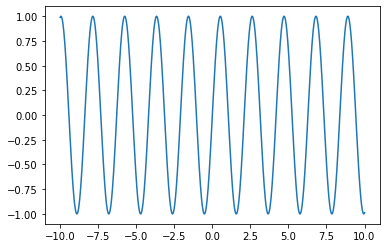

In [18]:
data = np.linspace(-10, 10, 2000)

plt.plot(data, np.sin(3 * data))

{'whiskers': [<matplotlib.lines.Line2D at 0x2086fd09430>,
 'caps': [<matplotlib.lines.Line2D at 0x2086fd09af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2086fd090d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2086fd1a1f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2086fd1a550>],
 'means': []}

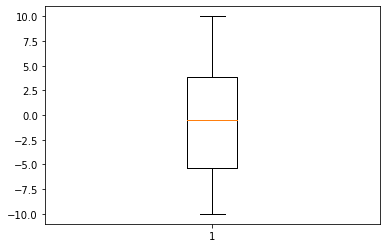

In [62]:
plt.boxplot(X_train)

In [47]:
#%pip install torch

  Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'c:\\Users\\sebas\\anaconda3\\Lib\\site-packages\\torch\\lib\\dnnl.lib'
Consider using the `--user` option or check the permissions.



  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3


  Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Can't uninstall 'typing-extensions'. No files were found to uninstall.


In [42]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [460]:
class SinNet(nn.Module):
    
    def __init__(self, n_hidden_neurons):
        super(SinNet, self).__init__()

        self.fc1 = nn.Linear(1, n_hidden_neurons)
        #nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(n_hidden_neurons, 1)
        #nn.init.xavier_normal_(self.fc2.weight)
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        #x = self.act2(x)
        x = self.fc2(x)
        return x

In [433]:
def fit_net(net, x, y, x_valid, y_valid, x_test, y_test, epoch = 100, lr = 0.01):
    x_valid = Variable(torch.from_numpy(x_valid)).unsqueeze_(1)
    y_valid = Variable(torch.from_numpy(y_valid)).unsqueeze_(1)
    x_test = Variable(torch.from_numpy(x_test)).unsqueeze_(1)
    y_test = Variable(torch.from_numpy(y_test)).unsqueeze_(1)
    x = Variable(torch.from_numpy(x), requires_grad=True).unsqueeze_(1)
    y = Variable(torch.from_numpy(y)).unsqueeze_(1)

    step_losses = []
    valid_losses = []
    train_losses = []
    test_losses = []

    loss = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)

    for _ in range(epoch):
        # y_pred_valid = net.forward(x_valid)
        # L_valid = loss(y_pred_valid, y_valid)
        # valid_losses.append(L_valid.item())

        # if ((len(step_losses) > 0) and (step_losses[-1] < L_valid.item())):
        #     step_losses.append(L_valid.item())
        # else:
        #     step_losses = [L_valid.item()]

        # y_pred_test = net.forward(x_test)
        # L_test = loss(y_pred_test, y_test)
        # test_losses.append(L_test.item())

        optimizer.zero_grad() 
        y_pred = net.forward(x)
        L = loss(y_pred, y)
        train_losses.append(L.item())

        if len(step_losses) >= 20:
            break

        L.backward()
        optimizer.step()

    return train_losses, valid_losses, test_losses

In [454]:
def visualize(net, x, x_input, title):
    x_input = Variable(torch.from_numpy(x_input))
    y = net.forward(x_input)

    plt.figure(figsize=(12, 8))
    plt.scatter(x, y.data.numpy(), c = 'r')
    plt.scatter(x, np.sin(3 * x), c = 'b')
    plt.title(title)
    plt.show()

In [461]:
net = SinNet(5)
print(net)

SinNet(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (act2): Sigmoid()
)


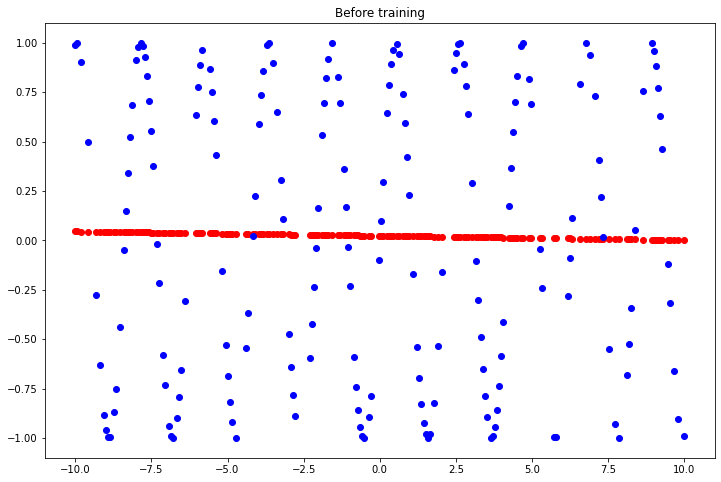

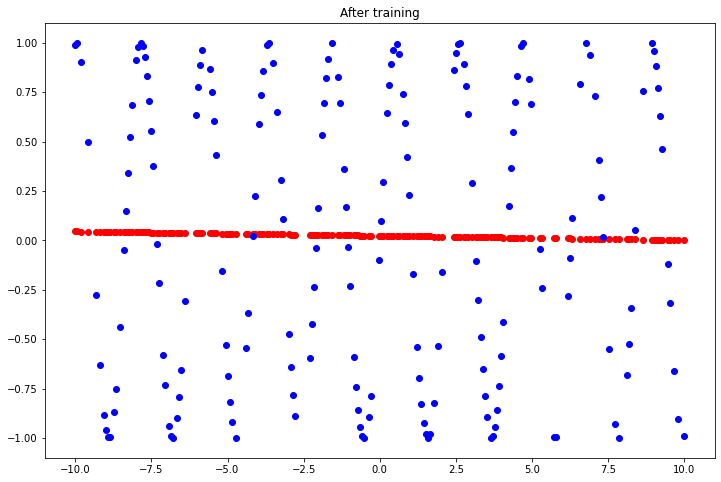

[0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943, 0.5135287642478943,

In [463]:
X_train_input = transformer.transform(X_train)
X_Validation_input = transformer.transform(X_Validation)
X_test_input = transformer.transform(X_test)


visualize(net, X_train, X_train_input, "Before training")

result = fit_net(net, X_train_input, y_train, X_Validation_input, y_Validation, X_test_input, y_test, epoch = 1000, lr = 0.05)

visualize(net, X_train, X_train_input, "After training")
print(result[0])
print(len(result[0]))